# Digging Into Economic Data: What Signals a Recession?

Let's dive into the economic data we've gathered and see what stories it tells us about past recessions. We'll look at patterns, spot interesting relationships, and get a feel for how different economic indicators behave when the economy takes a downturn.

In [1]:
# Import notebook utilities
from notebook_utils import (
    # Setup functions
    setup_notebook, load_data, display_data_info, save_figure,
    
    # Import from econ_downturn package
    plot_indicator_with_recessions, plot_correlation_matrix,
    plot_recession_correlations
)

# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Set up the notebook environment
setup_notebook()

Notebook environment set up successfully.
Available data paths:
  fred_dir: /home/mattgroho/github/economic-downturn-detector/data/fred
  nber_dir: /home/mattgroho/github/economic-downturn-detector/data/nber
  processed_dir: /home/mattgroho/github/economic-downturn-detector/data/processed
  fred_all_indicators: /home/mattgroho/github/economic-downturn-detector/data/fred/all_indicators.csv
  nber_recession_indicator: /home/mattgroho/github/economic-downturn-detector/data/nber/recession_indicator.csv
  merged_data: /home/mattgroho/github/economic-downturn-detector/data/processed/merged_data.csv
  data_with_features: /home/mattgroho/github/economic-downturn-detector/data/processed/data_with_features.csv
  data_normalized: /home/mattgroho/github/economic-downturn-detector/data/processed/data_normalized.csv
  data_pca: /home/mattgroho/github/economic-downturn-detector/data/processed/data_pca.csv

Available output paths:
  images_dir: /home/mattgroho/github/economic-downturn-detector/docs/im

## Getting Our Data Ready

Time to load up all our economic data. We've got indicators from FRED and recession dates from NBER - let's see what we're working with.

In [2]:
# Load all data using the utility function
merged_data = load_data(use_cached=True)

Loading cached merged data from /home/mattgroho/github/economic-downturn-detector/data/processed/merged_data.csv
2025-05-26 12:34:08,069 - econ_downturn.data.data_loader - INFO - Loaded merged data with shape: (15962, 13)
Loaded merged data with shape: (15962, 13)


## What Does Our Dataset Look Like?

Now that we've got everything loaded, let's take a closer look at what we're dealing with. How much data do we have? What's the time range? Any obvious issues we need to watch out for?

In [3]:
# Display information about the dataset
display_data_info(merged_data)

Dataset Information:
Time Range: 1970-01-01 00:00:00 to 2025-05-20 00:00:00
Number of Observations: 15962
Number of Features: 13

Summary Statistics:


,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,recession,SENTIMENT,INFLATION_1Y
count,221.000000,664.000000,664.000000,664.000000,12239.000000,2.889000e+03,664.000000,400.000000,664.000000,599.000000,664.000000,599.000000,567.000000
mean,12982.371271,6.077560,161.282611,4.908042,0.853785,3.708037e+05,75.447529,374689.555000,1434.793675,84.310518,0.126506,84.310518,3.583422
std,5327.027815,1.713823,75.904541,3.866685,0.923033,2.436837e+05,22.683262,147444.685415,406.944200,13.182718,0.332669,13.182718,1.614906
min,5299.672000,3.400000,37.900000,0.050000,-2.410000,1.890000e+05,36.388100,158647.000000,478.000000,50.000000,0.000000,50.000000,0.400000
25%,7880.794000,4.800000,101.025000,1.550000,0.180000,2.980000e+05,51.958475,265915.500000,1180.000000,73.750000,0.000000,73.750000,2.800000
50%,12471.010000,5.750000,161.000000,5.020000,0.810000,3.440000e+05,81.657600,352016.000000,1459.500000,87.600000,0.000000,87.600000,3.000000
75%,17031.313000,7.200000,224.953250,6.850000,1.490000,4.010000e+05,98.177300,455245.250000,1690.500000,94.150000,0.000000,94.150000,3.500000
max,23542.349000,14.800000,320.321000,19.100000,2.910000,6.137000e+06,104.149000,724131.000000,2494.000000,112.000000,1.000000,112.000000,10.400000



Missing Values:


,Missing Values,Percentage
GDP,15741,98.615462
RETAIL_SALES,15562,97.494048
INFLATION_1Y,15395,96.447814
CONSUMER_SENTIMENT,15363,96.247337
SENTIMENT,15363,96.247337
UNEMPLOYMENT,15298,95.840120
CPI,15298,95.840120
FED_FUNDS,15298,95.840120
INDUSTRIAL_PROD,15298,95.840120
HOUSING_STARTS,15298,95.840120


## Plotting the Economic Story

Time for the fun part - let's create some charts to see how these economic indicators have moved over the decades. We'll highlight recession periods so we can spot patterns and see which indicators might give us early warning signs.

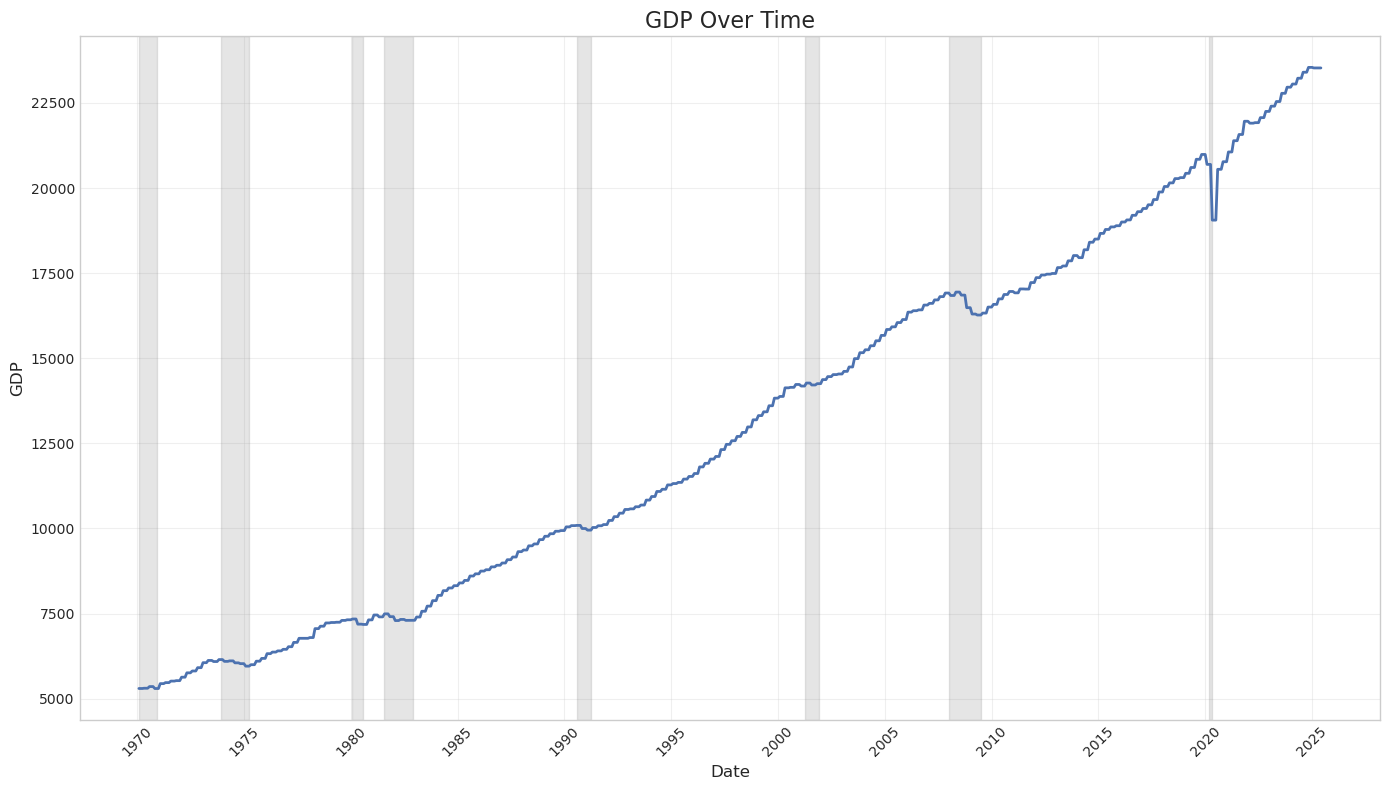

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/gdp_over_time.png


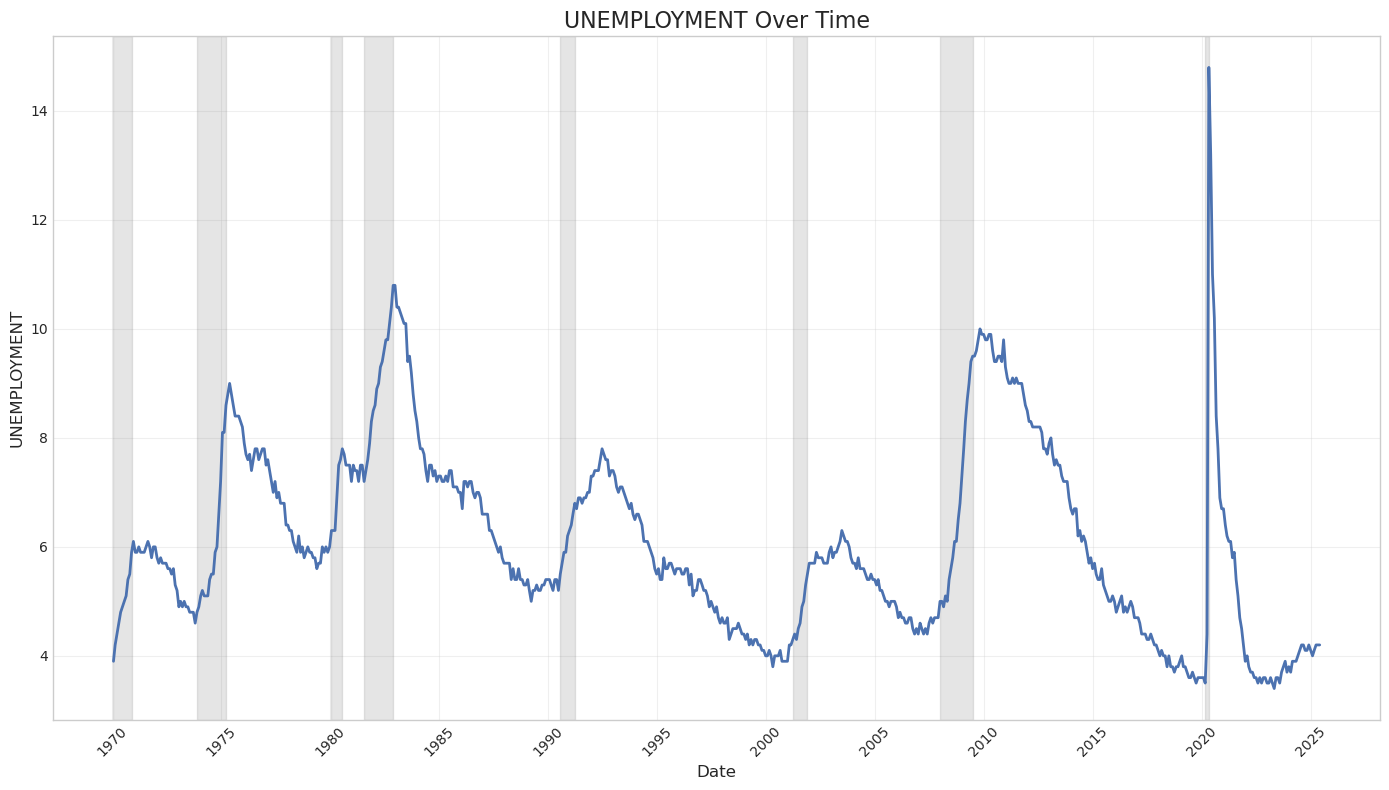

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/unemployment_over_time.png


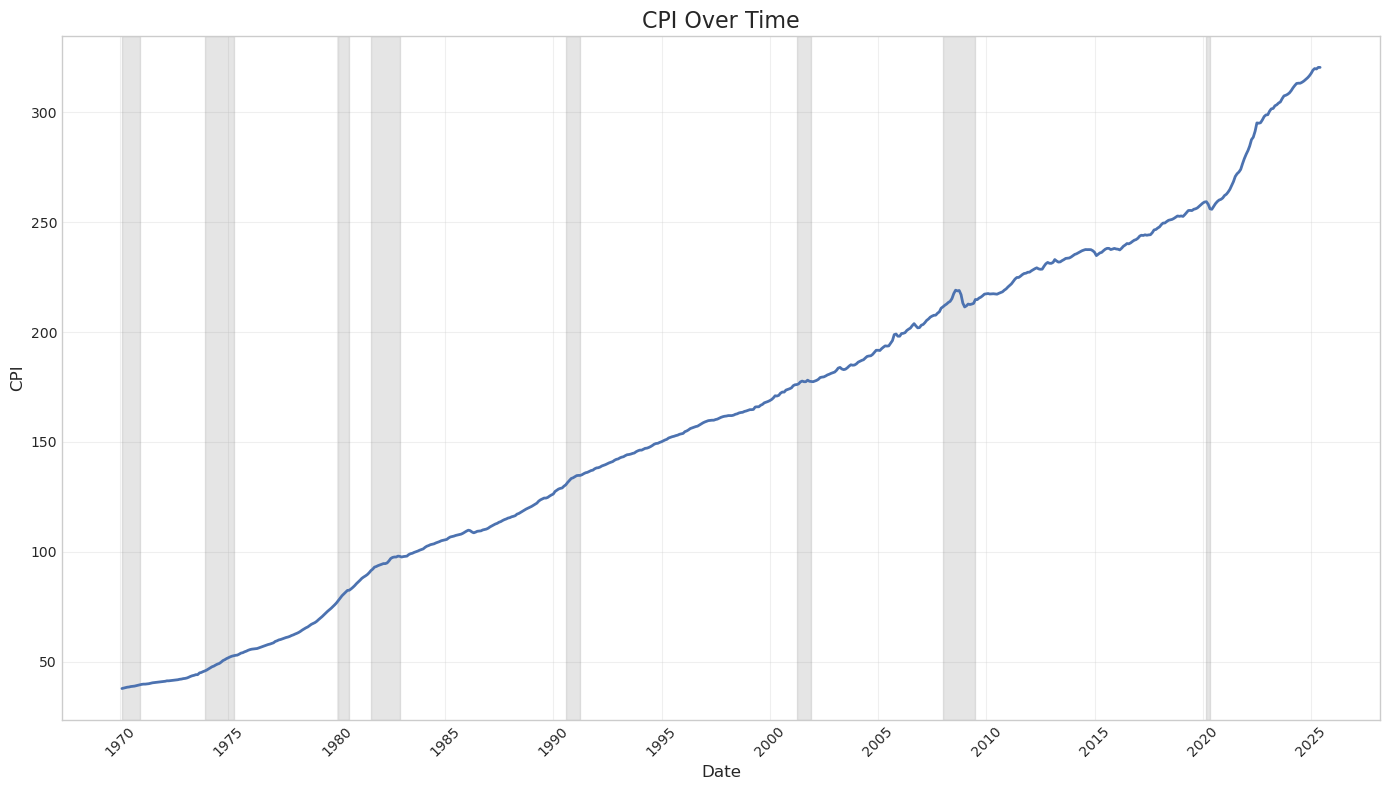

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/cpi_over_time.png


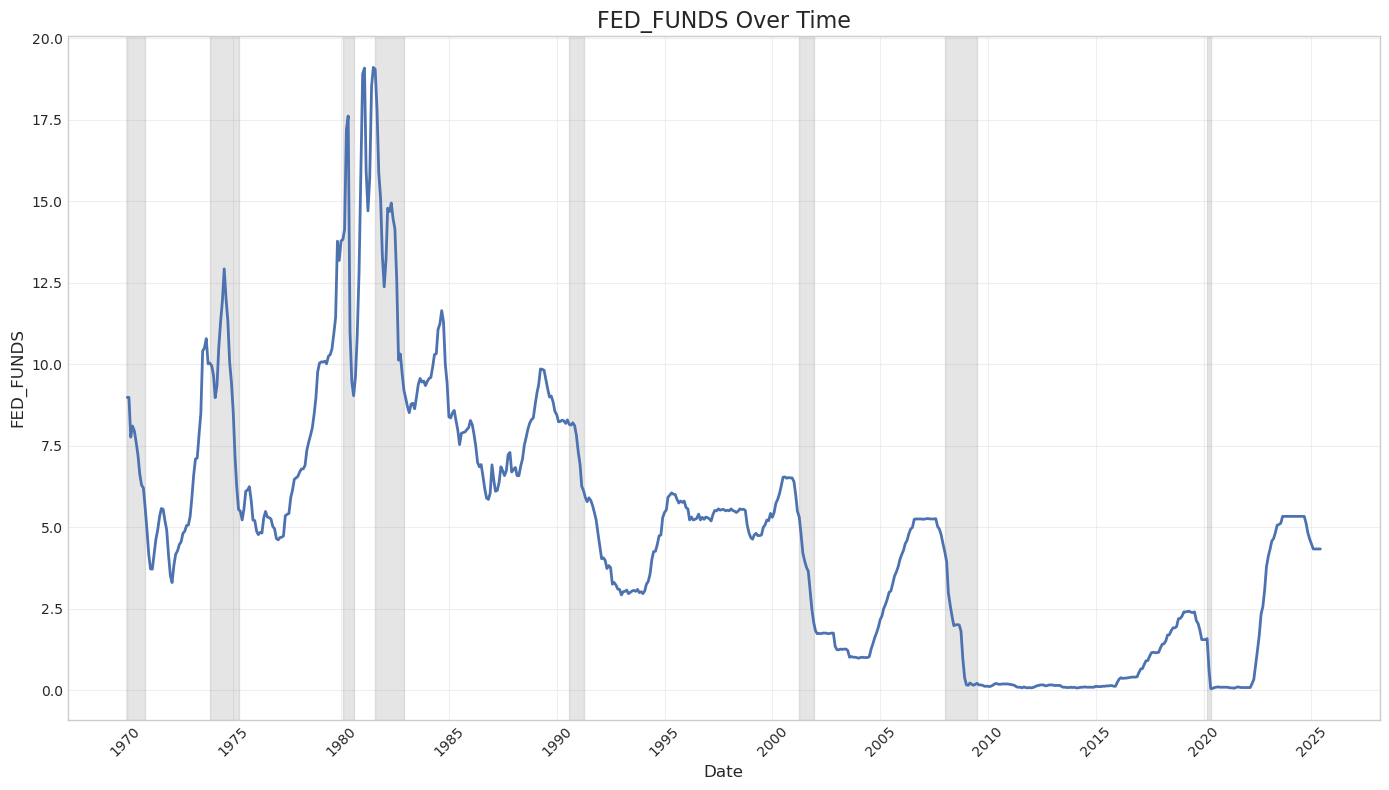

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/fed_funds_over_time.png


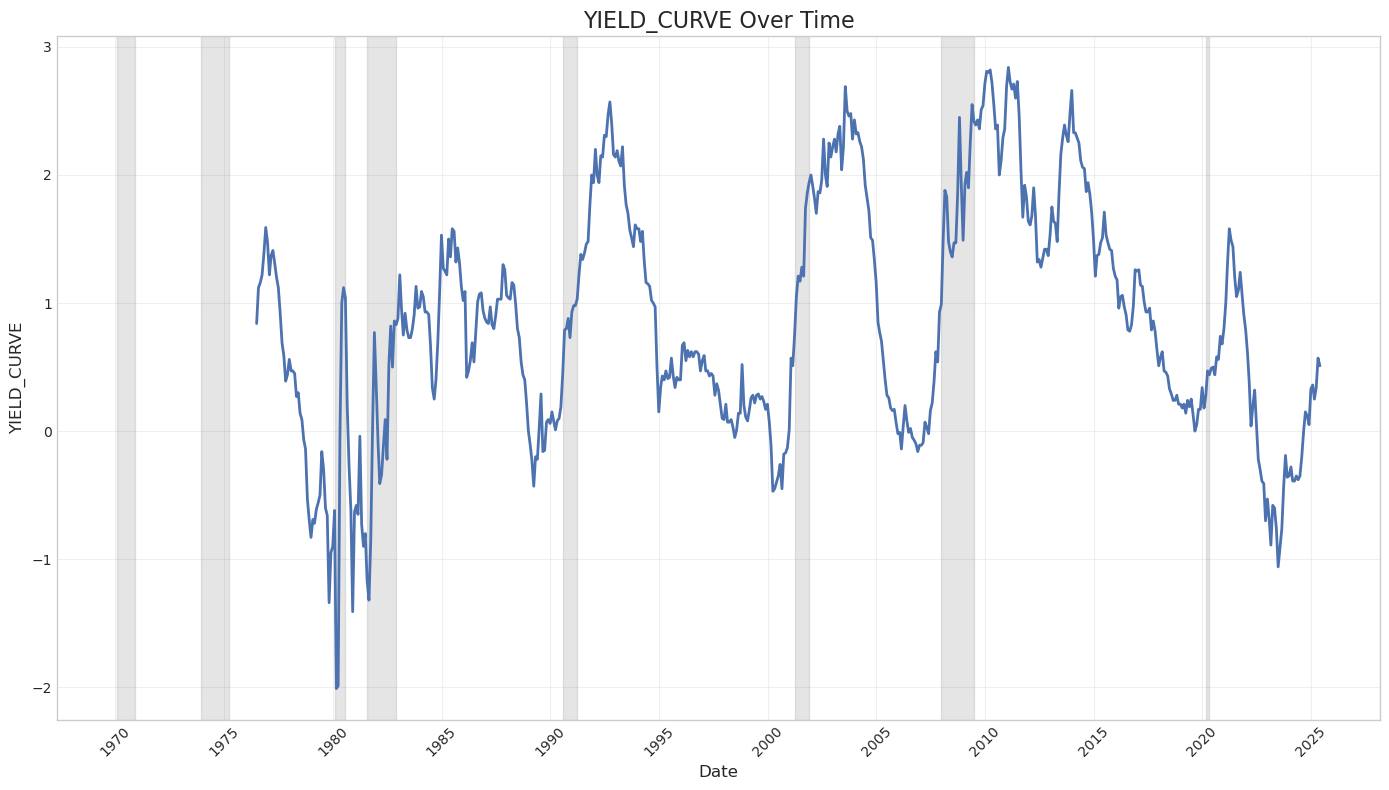

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/yield_curve_over_time.png


In [4]:
if merged_data is not None and 'recession' in merged_data.columns:
    # Plot key economic indicators
    indicators_to_plot = [
        col for col in merged_data.columns if col != 'recession'
    ]
    
    for indicator in indicators_to_plot[:5]:  # Plot first 5 indicators for brevity
        if indicator in merged_data.columns:
            fig = plot_indicator_with_recessions(
                merged_data, 
                indicator,
                title=f"{indicator} Over Time"
            )
            plt.show()
            
            # Save the figure
            save_figure(fig, f"{indicator.lower()}_over_time.png")

## 4. Correlation Analysis

Let's analyze the correlations between economic indicators and recession periods.

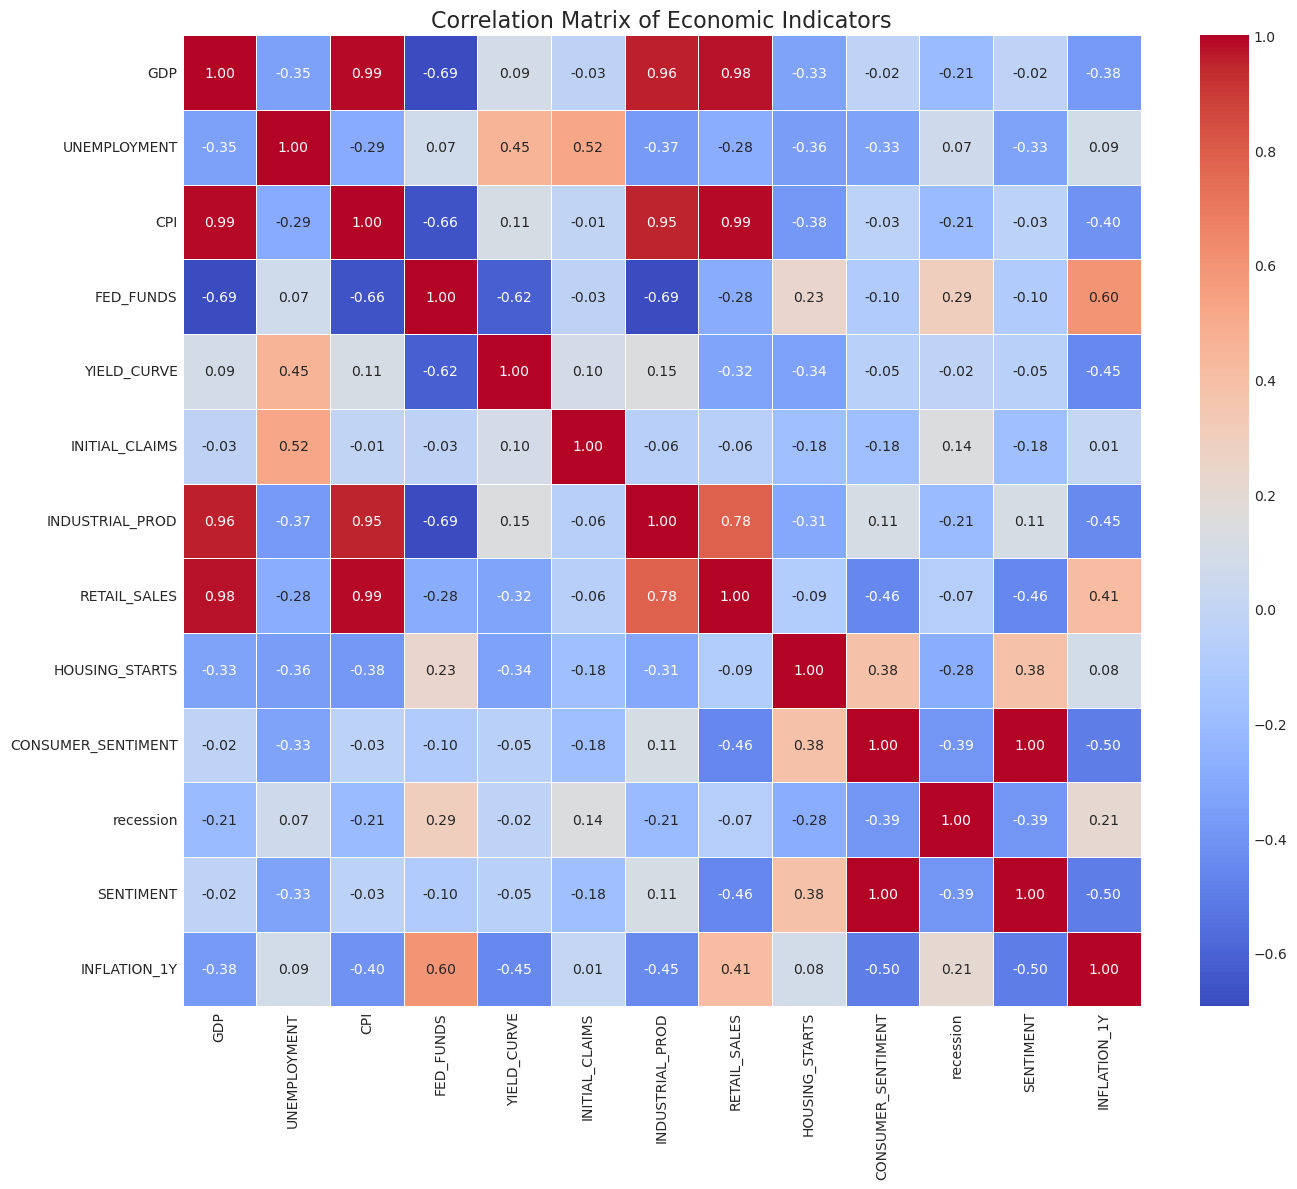

Saved figure to /home/mattgroho/github/economic-downturn-detector/docs/images/correlation_matrix.png


IndexError: list index out of range

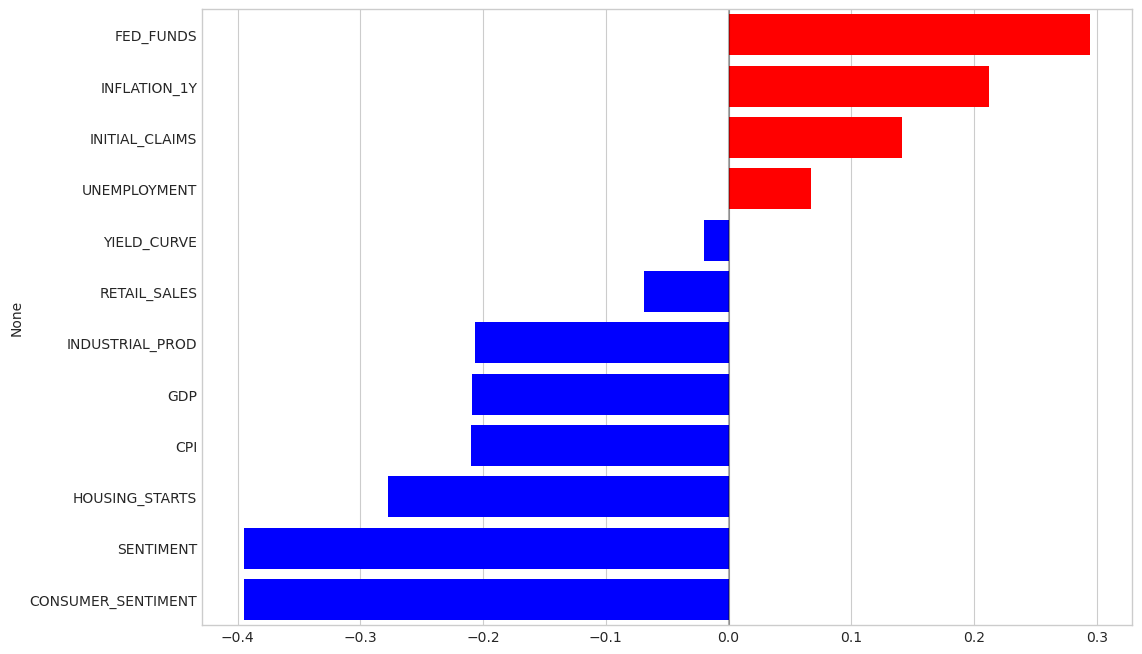

In [5]:
if merged_data is not None:
    # Plot correlation matrix
    fig = plot_correlation_matrix(merged_data)
    plt.show()
    save_figure(fig, "correlation_matrix.png")
    
    # If recession indicator is available, show correlations with recession
    if 'recession' in merged_data.columns:
        fig = plot_recession_correlations(merged_data)
        plt.show()
        save_figure(fig, "recession_correlations.png")

## 5. Next Steps

Based on the exploratory analysis, the next steps would be:

1. Handle missing values in the dataset
2. Create lag variables to capture leading indicators
3. Normalize the data for modeling
4. Apply Multiple Discriminant Analysis (MDA) to identify the most significant predictors of recessions
5. Evaluate the model's performance in classifying recessionary and non-recessionary periods